In [7]:
import pandas as pd
import numpy as np
import cv2
from skimage import color
from skimage import io
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import os
import pickle
import csv
import sklearn.metrics as skm
from tensorflow import keras
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [10]:
# Directories path
ALL_DATA = 'dataset'
DATA_DIR = os.path.join(ALL_DATA, 'Datasets_10_labels_RGB')
IMG_DIR = os.path.join(DATA_DIR, 'train')

## 1. Image Preprocessing

In [3]:
train_csv = pd.read_csv(os.path.join(ALL_DATA, 'train.csv'))
train_csv.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [48]:
labels_freq = defaultdict(int)

for r in train_csv['Target']:
    labels = r.split()
    for l in labels:
        labels_freq[l] += 1

labels_list = list(labels_freq.keys())

print('Images: {} \nLabels: {}'.format(len(train_csv['Id']), len(labels_list)))

Images: 31072 
Labels: 28


<Figure size 1440x216 with 0 Axes>

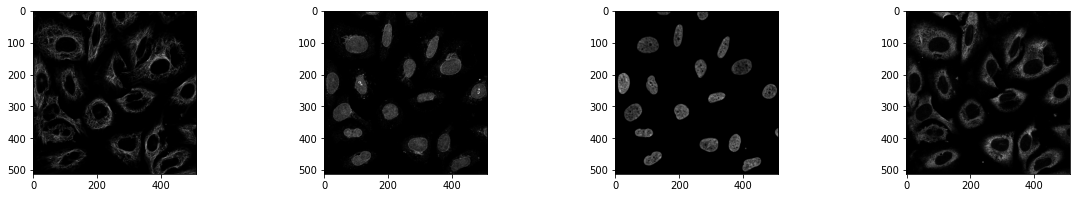

In [40]:
# Checkout image data

img_id = train_csv['Id'][1]
channels = ['red','green', 'blue', 'yellow']

def get_images(img_id, channels):
    img_red = img_id + '_' + channels[0] + '.png'
    img_green = img_id + '_' + channels[1] + '.png'
    img_blue = img_id + '_' + channels[2] + '.png'
    img_yellow = img_id + '_' + channels[3] + '.png'
    red = cv2.imread(os.path.join(ALL_DATA, 'train', img_red))
    green = cv2.imread(os.path.join(ALL_DATA, 'train', img_green))
    blue = cv2.imread(os.path.join(ALL_DATA, 'train', img_blue))
    yellow = cv2.imread(os.path.join(ALL_DATA, 'train', img_yellow))
    
    return red, green, blue, yellow

red, green, blue, yellow = get_images(img_id, channels)

# visualize the images
plt.figure()
f, axarr = plt.subplots(1, 4) 
axarr[0].imshow(red)
axarr[1].imshow(green)
axarr[2].imshow(blue)
axarr[3].imshow(yellow)
plt.rcParams["figure.figsize"] = (40,3)
plt.show(f)

### Different channels:

All Image samples are represented by the four filters:

1. Red: Microtubules
2. Green: Protein of interest
3. Blue: Nucleus
4. Yellow: Endoplasmic Reticulum

**The green filter should hence be used to predict the label, and the other filters are used as references.**

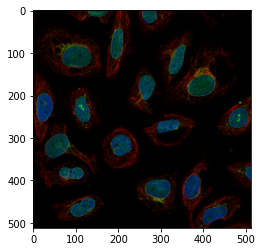

In [45]:
def merge(red, green, blue):
    red = cv2.cvtColor(red, cv2.COLOR_BGR2GRAY)
    green = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)
    blue = cv2.cvtColor(blue, cv2.COLOR_BGR2GRAY)
    
    rgb = np.dstack((red, green, blue)) # (h, w, 3)
    return rgb

rgb = merge(red, green, blue)
plt.figure(figsize=(4,4))
plt.imshow(rgb)

## Multi-label image classification - 9 labels

- Modify train.csv file to get Ids for initial 9 labels

In [11]:
tuning_labels = pd.read_csv(DATA_DIR + '/final1.csv', index_col=['Id'])
tuning_labels.head()

,Target
Id,
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0


In [30]:
tuning_labels_freq = defaultdict(int)

for r in tuning_labels['Target']:
    labels = r.split()
    for l in labels:
        tuning_labels_freq[l] += 1
        
tuning_labels_list = list(tuning_labels_freq.keys())
print('Unique tuning labels', len(tuning_labels_list))
print('Label list: ',tuning_labels_list)
tuning_labels_freq

Unique tuning labels 9
Label list:  ['0', '7', '1', '2', '5', '6', '3', '4', '8']


defaultdict(int,
            {'0': 12885,
             '7': 2822,
             '1': 1254,
             '2': 3621,
             '5': 2513,
             '6': 1008,
             '3': 1561,
             '4': 1858,
             '8': 53})

In [13]:
label_2_idx = {}
idx_2_label = {}
for idx,label in enumerate(tuning_labels_list):
    label_2_idx[label] = idx
    idx_2_label[idx] = label

In [14]:
# Load class names
class_descriptions = pd.read_csv(DATA_DIR + '/names.csv', index_col='Code')
class_descriptions['Name']

Code
0                  Nucleoplasm
1                      Cytosol
2              Plasma membrane
3                     Nucleoli
4                 Mitochondria
5              Golgi apparatus
6               Nuclear bodies
7             Nuclear spackles
8    Nucleoli fibrillar center
Name: Name, dtype: object

In [15]:
all_img_ids = list(tuning_labels.index.unique())

# Split dataset into, train - validation - test
train_ids, test_ids = train_test_split(all_img_ids, test_size=0.01, random_state=21)
train_ids, valid_ids = train_test_split(train_ids, test_size=0.1, random_state=21)

print('Training on {} samples'.format(len(train_ids)))
print('Validating on {} samples'.format(len(valid_ids)))
print('Testing on {} samples'.format(len(test_ids)))

Training on 19537 samples
Validating on 2171 samples
Testing on 220 samples


In [16]:
N_CLASSES = len(label_2_idx)
BATCH_SIZE = 8
INPUT_SIZE = 224

In [17]:
def caption_2_one_hot(caption, 
                      n_classes=1, 
                      lookup_dict=None):
    y = np.zeros((n_classes))
    for w in caption.split():
        idx = lookup_dict[w]
        y[idx] = 1
    return y

def ImageDataGen(ids, df,
                 lookup_dict=label_2_idx,
                 n_classes=N_CLASSES,
                 img_dir=IMG_DIR, 
                 input_size=INPUT_SIZE,
                 bs=BATCH_SIZE, 
                 returnIds=False):
    while True:
        for start in range(0, len(ids), bs):
            x_batch = []
            y_batch = []
            end = min(start+bs, len(ids))
            sample = ids[start:end]
            for img_id in sample:
                img = cv2.imread('{}/{}.jpg'.format(img_dir, img_id))
                if img is not None:
                    img = cv2.resize(img, (input_size, input_size))
                    img = preprocess_input(img.astype(np.float32))
                    x_batch.append(img)
                    caption = df.loc[img_id]['Target']
                    y = caption_2_one_hot(caption, n_classes=n_classes, lookup_dict=lookup_dict)
                    y_batch.append(y)
                    
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            
            if returnIds:
                yield x_batch, y_batch, sample
            else:
                yield x_batch, y_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


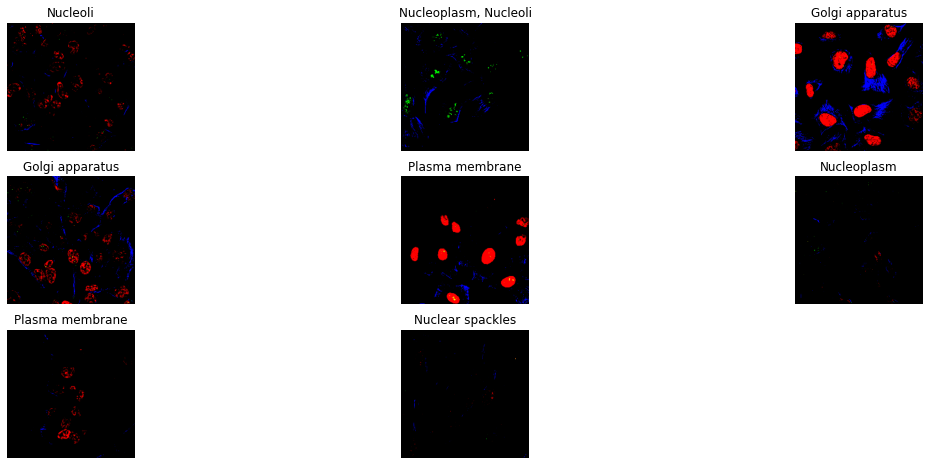

In [18]:
test_gen = ImageDataGen(test_ids, tuning_labels)
test_batch = next(test_gen)
fig = plt.figure(figsize=(20, 8))
for sample_idx in range(BATCH_SIZE):
    ax = fig.add_subplot(3,3, sample_idx + 1)
    ax.set_title(', '.join([class_descriptions.loc[int(idx_2_label[i])]['Name'] for i in (np.argwhere(test_batch[1][sample_idx]>0)).flatten()]))
    ax.imshow(test_batch[0][sample_idx])
    ax.set_axis_off()
plt.show()

## 2. Configure model

- Base model: DenseNet121
- Last layer: Number of N_classes followed by **Sigmoid activation**

In [20]:
def ClsssModel(n_classes=1, input_shape=(224,224,3)):
    base_model1 = DenseNet121(weights=None, include_top=False, input_shape=input_shape)
    x = AveragePooling2D(pool_size=(3,3), name='avg_pool')(base_model1.output)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='dense_post_pool')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_classes, activation='sigmoid', name='predictions')(x)
    model1 = Model(base_model1.input, output)
    return model1

model1 = ClsssModel(9, (224,224,3))
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [21]:
model1.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model_checkpoint = ModelCheckpoint(('./densenet.{epoch:02d}.hdf5'),
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                         patience=2, verbose=1)

callbacks = [model_checkpoint, reduce_learning_rate]

In [24]:
train_gen = ImageDataGen(train_ids, tuning_labels)
valid_gen = ImageDataGen(valid_ids, tuning_labels)

## 3. Train & Test

In [25]:
model1.fit_generator(generator=train_gen, 
                    epochs=1, 
                    steps_per_epoch=int(np.ceil(len(train_ids)/BATCH_SIZE)),
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=int(np.ceil(len(valid_ids) / BATCH_SIZE)))

c:\users\manthan\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


   7/2443 [..............................] - ETA: 2:52:48 - loss: 0.8438 - accuracy: 0.3445

KeyboardInterrupt: 

In [26]:
#on server

model1.save('/home/dlagroup29/parthmanthan/Data/model/Densenet121_4_channel/model_Densenet121.h5')
model1.save_weights('/home/dlagroup29/parthmanthan/Data/model/Densenet121_4_channel/weights_Densenet121.h5')

In [21]:
# Load checkpoint
model1 = keras.models.load_model('saved_model/model_4.h5')

In [19]:
test_gen = ImageDataGen(test_ids, tuning_labels)
test_batch = next(test_gen)

In [22]:
# predictions

test_pred = model1.predict(test_batch[0])
test_preds = test_pred
test_data = test_batch[1]

In [23]:
# print(test_preds.shape)

print(test_data.shape)

(8, 9)


In [24]:
#put test_data batchwise

for i in range(50):
    test_pred = model1.predict(test_batch[0])
    test_preds = np.concatenate((test_preds, test_pred), axis = 0)
    test_batch = next(test_gen)
    test_data = np.concatenate((test_data, test_batch[1]), axis = 0)
test_preds[:-1, :]

array([[3.3487403e-01, 1.8715027e-01, 6.5652162e-02, ..., 1.2663960e-01,
        7.7985585e-02, 8.6729228e-03],
       [9.8717320e-01, 5.2841306e-03, 2.9962597e-05, ..., 1.8617777e-05,
        1.6283691e-03, 1.0972304e-14],
       [7.6254833e-01, 7.4796528e-02, 3.6244005e-02, ..., 3.6599129e-02,
        9.6514165e-02, 1.3202429e-04],
       ...,
       [9.7940105e-01, 7.0548654e-03, 9.1029055e-05, ..., 6.0113940e-05,
        3.1308830e-03, 2.5190855e-13],
       [9.8216414e-01, 5.6000352e-03, 2.6943111e-05, ..., 2.3315541e-05,
        1.3488531e-03, 3.0044035e-14],
       [3.1664270e-01, 1.9567567e-01, 7.1077794e-02, ..., 1.3571995e-01,
        8.0241948e-02, 1.2133360e-02]], dtype=float32)

In [25]:
# print(test_preds.shape)
print(test_data.shape)

(404, 9)


### Other measures - precision, recall & F1 score

In [26]:
# precision, recall, f1 

def print_score(threshold, test_data, test_preds):
    print('threshold: ' + str(threshold))
    precision, recall, fscore, support = score(test_data, test_data > 0.2, average='samples')

    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))

In [27]:
#Score tabel - labelwise

def print_score_table(threshold, test_data, test_preds):
    print('threshold: ' + str(threshold))
    precision, recall, fscore, support = score(test_data, test_preds > threshold, average=None)
    print('index', end='  ')
    print('precision', end='  ')
    print('recall', end='  ')
    print('f1score', end='  ')
    print('support')
    print(42*'-')
    for i in range(test_data.shape[1]):
        print(str(i), end='  ')
        print('{0:8.4}'.format(precision[i]), end='  ')
        print('{0:8.4}'.format(recall[i]), end='  ')
        print('{0:8.4}'.format(fscore[i]), end='  ')
        print('{0:8}'.format(support[i]))

In [28]:
#Print value

print_score(0.1, test_data, test_preds)
print_score(0.2, test_data, test_preds)
print_score(0.3, test_data, test_preds)
print_score_table(0.1, test_data, test_preds)
print_score_table(0.2, test_data, test_preds)
print_score_table(0.3, test_data, test_preds)

threshold: 0.1
precision: 1.0
recall: 1.0
fscore: 1.0
support: None
threshold: 0.2
precision: 1.0
recall: 1.0
fscore: 1.0
support: None
threshold: 0.3
precision: 1.0
recall: 1.0
fscore: 1.0
support: None
threshold: 0.1
index  precision  recall  f1score  support
------------------------------------------
0    0.6213       1.0    0.7664       251
1    0.1053      0.08   0.09091        50
2       0.0       0.0       0.0        29
3    0.1037    0.2881    0.1525        59
4       0.2    0.3684    0.2593        38
5    0.5714    0.1905    0.2857        21
6   0.05556     0.025   0.03448        40
7   0.05556     0.125   0.07692        40
8       0.0       0.0       0.0         0
threshold: 0.2
index  precision  recall  f1score  support
------------------------------------------
0    0.6213       1.0    0.7664       251
1       0.0       0.0       0.0        50
2       0.0       0.0       0.0        29
3       0.0       0.0       0.0        59
4       0.0       0.0       0.0        38
5     

c:\users\manthan\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\manthan\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\manthan\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\manthan\anaconda3\envs\t

In [ ]:
"""

Further Implementations:

- Data Augmentations
- Statified distribution of data for train, val & test
- Image standardization
- K - fold cross-validaton
- Learning rate scheduler

"""